In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 4096
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "ll3_fitting/epoch_299", # Continue training from result after epoch 299
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth: Fast Llama patching release 2024.7
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.988 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth 2024.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [2]:
# Load the training and evaluation dataset (the eval dataset is same as origin llama3-8b-instruct)
import pickle
with open('data/llama3trainingdataset.pkl', 'rb') as f:
    training_dataset = pickle.load(f)

In [3]:
training_dataset = [{'conversations': i} for i in training_dataset]
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

training_dataset = Dataset.from_list(training_dataset)

In [4]:
train_test_split = training_dataset.train_test_split(test_size=0.166666, shuffle=False) # same dataset

train_dataset = train_test_split['train'] # 50000 instance
valid_dataset = train_test_split['test']  # 10000 instance
print(train_dataset)
print(valid_dataset)

Dataset({
    features: ['conversations'],
    num_rows: 50000
})
Dataset({
    features: ['conversations'],
    num_rows: 10000
})


In [5]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3"
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
valid_dataset = valid_dataset.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
# inspect the format of three datasets, all should looks the same
print(train_dataset[0])
print('---------------')
print(valid_dataset[0])

{'conversations': [{'content': "You are a personal judge of video game, your role is to judge which game is preferred by the user based on user's feedbacks of two games. Simply reply with prefered game's name, no need for explanation", 'role': 'system'}, {'content': 'I played two games counterstrike: source, and fallout: a post nuclear role playing game. After playing, I gave reviews for both games as follow:\ncounterstrike: source: good gmod texture pack\nfallout: a post nuclear role playing game: this games mom is a critical failure', 'role': 'user'}, {'content': 'counterstrike: source', 'role': 'assistant'}], 'text': "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a personal judge of video game, your role is to judge which game is preferred by the user based on user's feedbacks of two games. Simply reply with prefered game's name, no need for explanation<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nI played two games counterstrike: source, and fallout

In [7]:
# define trainer with parameters
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = valid_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 2,
        warmup_steps = 0,
        max_steps = 1,
        learning_rate = 1e-6,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        lr_scheduler_type = "linear",
        output_dir = "outputs",
        save_total_limit=5,  # Save only the top 5 models
        load_best_model_at_end=True,  # Load the best model at the end of training
        metric_for_best_model="loss",  # Use loss to determine the best model
        greater_is_better=False,  # Lower loss is better
        evaluation_strategy="steps",  # Set evaluation strategy to steps
        save_strategy="steps",  # Set save strategy to steps
        eval_steps=1,  # Evaluate every 10 steps (set this as needed)
    ),
)

/home/yuchen/miniconda3/envs/unsloth/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map (num_proc=2):   0%|          | 0/50000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/10000 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [8]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4090. Max memory = 23.988 GB.
5.75 GB of memory reserved.


In [9]:
validation_losses = []
for i in range(300, 500, 1):
    trainer.train()
    history = trainer.state.log_history
    validation_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]
    validation_losses = validation_losses + validation_loss
    model.save_pretrained(f"ll3_fitting/epoch_{i}") 

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.841900,2.434211


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.841000,2.429114


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.832400,2.426055


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.827200,2.420868


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.819200,2.417165


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.812500,2.413580


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.804900,2.408641


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.797500,2.403598


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.791500,2.398049


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.786400,2.394947


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.779600,2.390295


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.774100,2.386225


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.766800,2.380778


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.761800,2.374652


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.754900,2.373192


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.745600,2.367068


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.739600,2.363101


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.735000,2.358874


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.728500,2.354233


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.721000,2.349811


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.715000,2.344890


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.706900,2.339416


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.697500,2.334209


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.694600,2.330821


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.686200,2.325868


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.678800,2.321382


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.673300,2.316366


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.666900,2.312277


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.658000,2.306243


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.647000,2.301701


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.645600,2.296497


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.633300,2.291540


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.628600,2.287091


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.622600,2.281320


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.612700,2.277779


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.605600,2.271318


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.599100,2.266006


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.594100,2.261793


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.585700,2.257057


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.579200,2.250715


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.570300,2.246100


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.560600,2.241559


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.553300,2.234711


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.549900,2.229675


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.540400,2.223116


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.533000,2.219692


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.524300,2.214256


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.514500,2.208559


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.508300,2.202083


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.500700,2.196841


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.494900,2.191184


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.484000,2.184117


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.477400,2.178318


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.467600,2.172524


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.457200,2.166753


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.448400,2.160771


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.445500,2.154267


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.428700,2.147717


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.425200,2.142635


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.414800,2.135309


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.408800,2.130309


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.394700,2.123697


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.390800,2.119979


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.384000,2.110849


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.372500,2.105269


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.365700,2.099814


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.355000,2.095284


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.351200,2.089105


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.340000,2.083326


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.333200,2.079146


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.324000,2.073535


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.315500,2.068060


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.307500,2.063475


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.302400,2.058094


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.297000,2.054322


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.289400,2.049976


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.281200,2.045795


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.276500,2.042159


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.268800,2.038114


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.263200,2.033205


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.256200,2.030665


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.245800,2.026552


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.243200,2.023489


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.238800,2.020697


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.230500,2.017652


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.223600,2.014360


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.219300,2.011736


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.212300,2.008301


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.205100,2.006024


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.202500,2.004094


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.195000,2.000878


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.192200,1.998774


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.183100,1.996488


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.179000,1.995406


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.174200,1.992670


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.171300,1.990888


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.163800,1.989233


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.160300,1.987359


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.155300,1.984964


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.147200,1.983761


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.142800,1.981142


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.137400,1.981165


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.134100,1.979180


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.127900,1.978400


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.123100,1.976055


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.120800,1.975169


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.112500,1.974128


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.105600,1.972677


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.101500,1.971141


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.096900,1.970277


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.090600,1.969307


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.083200,1.967784


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.079800,1.967262


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.074500,1.966331


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.068500,1.964579


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.064600,1.963560


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.058400,1.962975


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.052700,1.962633


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.048200,1.961139


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.041100,1.961177


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.037400,1.959911


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.034900,1.958777


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.027900,1.958299


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.024000,1.957436


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.018000,1.957324


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.013200,1.957060


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.004100,1.956171


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,1.001900,1.955311


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.995000,1.955904


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.991300,1.955194


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.984800,1.953659


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.980300,1.953336


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.974300,1.953265


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.969600,1.952837


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.966300,1.952333


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.960600,1.952854


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.953500,1.953281


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.948600,1.952855


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.943300,1.951948


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.939100,1.953055


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.931600,1.952090


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.929400,1.952947


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.921900,1.952892


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.917300,1.952986


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.912700,1.953802


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.910000,1.953842


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.902900,1.954129


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.898700,1.953820


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.892400,1.955548


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.887800,1.955225


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.882400,1.955232


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.877400,1.956382


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.874700,1.955482


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.871800,1.955171


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.865000,1.955781


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.859300,1.956736


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.855600,1.956361


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.853600,1.957296


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.845100,1.958475


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.842300,1.958849


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.837500,1.961474


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.831600,1.961930


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.828700,1.963300


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.824700,1.964238


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.822100,1.965045


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.816700,1.965318


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.812400,1.967301


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.812600,1.969040


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.804800,1.968373


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.803000,1.970281


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.797900,1.970061


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.794300,1.972155


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.791100,1.971255


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.787700,1.975463


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.783100,1.974572


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.779100,1.974685


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.775600,1.976898


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.770700,1.976869


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.767700,1.976133


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.763200,1.979082


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.759900,1.980265


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.757600,1.980420


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.752500,1.983397


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.747400,1.984187


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.745000,1.986259


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.741000,1.987781


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.736400,1.989987


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.734500,1.991654


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.728900,1.992783


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.725900,1.996768


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.722100,1.999654


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.719000,2.000070


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.715100,2.002621


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.709400,2.007677


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.706700,2.007936


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.703800,2.013601


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.698300,2.013596


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.695400,2.016584


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.691900,2.019929


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 2
\        /    Total batch size = 2 | Total steps = 1
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
1,0.688000,2.024095


In [2]:
training_losses = [3.5913, 3.5850, 3.5953, 3.5852, 3.5829, 3.5859, 3.5869, 3.5837, 3.5866, 3.5858] +\
    [3.5879, 3.5872, 3.5826, 3.5827, 3.5810, 3.5810, 3.5797, 3.5819, 3.5792, 3.5780] +\
    [3.5791, 3.5768, 3.5752, 3.5707, 3.5715, 3.5724, 3.5715, 3.5695, 3.5730, 3.5677] +\
    [3.5650, 3.5625, 3.5655, 3.5630, 3.5564, 3.5587, 3.5602, 3.5585, 3.5560, 3.5476] +\
    [3.5501, 3.5495, 3.5447, 3.5453, 3.5426, 3.5413, 3.5403, 3.5387, 3.5368, 3.5356] +\
    [3.5335, 3.5269, 3.5249, 3.5288, 3.5242, 3.5236, 3.5222, 3.5171, 3.5164, 3.5112] +\
    [3.5117, 3.5078, 3.5052, 3.5040, 3.5009, 3.4988, 3.4981, 3.4922, 3.4954, 3.4878] +\
    [3.4828, 3.4805, 3.4821, 3.4768, 3.4735, 3.4699, 3.4667, 3.4628, 3.4637, 3.4585] +\
    [3.4577, 3.4534, 3.4474, 3.4472, 3.4358, 3.4378, 3.4316, 3.4335, 3.4266, 3.4208] +\
    [3.4223, 3.4713, 3.4107, 3.4068, 3.4044, 3.3963, 3.3958, 3.3861, 3.3824, 3.3801] +\
    [3.3731, 3.3706, 3.3624, 3.3602, 3.3568, 3.3505, 3.3475, 3.3445, 3.3399, 3.3349] +\
    [3.3297, 3.3229, 3.3219, 3.3147, 3.3120, 3.3075, 3.2970, 3.2964, 3.2895, 3.2857] +\
    [3.2808, 3.2745, 3.2716, 3.2654, 3.2544, 3.2506, 3.2457, 3.2404, 3.2380, 3.2310] +\
    [3.2286, 3.2235, 3.2102, 3.2080, 3.2011, 3.2001, 3.1903, 3.1868, 3.1791, 3.1753] +\
    [3.1656, 3.1607, 3.1552, 3.1499, 3.1429, 3.1364, 3.1298, 3.1236, 3.1204, 3.1155] +\
    [3.1043, 3.1007, 3.0939, 3.0869, 3.0814, 3.0755, 3.0690, 3.0580, 3.0571, 3.0450] +\
    [3.0424, 3.0375, 3.0285, 3.0236, 3.0159, 3.0051, 3.0017, 2.9945, 2.9910, 2.9823] +\
    [2.9762, 2.9677, 2.9658, 2.9537, 2.9447, 2.9399, 2.9351, 2.9285, 2.9174, 2.9098] +\
    [2.9067, 2.8959, 2.8939, 2.8840, 2.8791, 2.8690, 2.8642, 2.8545, 2.8483, 2.8388] +\
    [2.8354, 2.8263, 2.8178, 2.8111, 2.7992, 2.7927, 2.7869, 2.7765, 2.7734, 2.7637] +\
    [2.7554, 2.7499, 2.7420, 2.7335, 2.7258, 2.7194, 2.7091, 2.7000, 2.6983, 2.6867] +\
    [2.6758, 2.6690, 2.6625, 2.6568, 2.6439, 2.6372, 2.6270, 2.6205, 2.6089, 2.6023] +\
    [2.5995, 2.5863, 2.5768, 2.5699, 2.5575, 2.5522, 2.5448, 2.5354, 2.5241, 2.5166] +\
    [2.5043, 2.4982, 2.4483, 2.4784, 2.4682, 2.4604, 2.4514, 2.4391, 2.4361, 2.4230] +\
    [2.4112, 2.4030, 2.3946, 2.3879, 2.3777, 2.3670, 2.3589, 2.3479, 2.3400, 2.3291] +\
    [2.3207, 2.3120, 2.3027, 2.2926, 2.2827, 2.2728, 2.2650, 2.2576, 2.2484, 2.2367] +\
    [2.2231, 2.2178, 2.2058, 2.1985, 2.1900, 2.1825, 2.1729, 2.1626, 2.1536, 2.1480] +\
    [2.1388, 2.1276, 2.1197, 2.1105, 2.1025, 2.0896, 2.0836, 2.0706, 2.0631, 2.0540] +\
    [2.0441, 2.0363, 2.0274, 2.0152, 2.0061, 1.9964, 1.9851, 1.9789, 1.9679, 1.9604] +\
    [1.9501, 1.9384, 1.9287, 1.9169, 1.9083, 1.9012, 1.8862, 1.8758, 1.8705, 1.8554] +\
    [1.8419, 1.8410, 1.8324, 1.8272, 1.8192, 1.8125, 1.8049, 1.7975, 1.7915, 1.7864] +\
    [1.7796, 1.7741, 1.7668, 1.7618, 1.7549, 1.7456, 1.7396, 1.7350, 1.7285, 1.7210] +\
    [1.7150, 1.7069, 1.6975, 1.6946, 1.6862, 1.6788, 1.6733, 1.6669, 1.6580, 1.6470] +\
    [1.6456, 1.6333, 1.6286, 1.6226, 1.6217, 1.6056, 1.5991, 1.5941, 1.5857, 1.5792] +\
    [1.5703, 1.5606, 1.5533, 1.5499, 1.5404, 1.5330, 1.5243, 1.5145, 1.5083, 1.5007] +\
    [1.4949, 1.4840, 1.4774, 1.4676, 1.4572, 1.4484, 1.4455, 1.4287, 1.4252, 1.4148] +\
    [1.4088, 1.3947, 1.3908, 1.3840, 1.3725, 1.3657, 1.3550, 1.3512, 1.3400, 1.3332] +\
    [1.3240, 1.3155, 1.3075, 1.3024, 1.2970, 1.2894, 1.2812, 1.2765, 1.2688, 1.2632] +\
    [1.2562, 1.2458, 1.2432, 1.2388, 1.2305, 1.2236, 1.2193, 1.2123, 1.2051, 1.2025] +\
    [1.1950, 1.1922, 1.1831, 1.1790, 1.1742, 1.1713, 1.1638, 1.1603, 1.1553, 1.1472] +\
    [1.1428, 1.1374, 1.1341, 1.1279, 1.1231, 1.1208, 1.1125, 1.1056, 1.1015, 1.0969] +\
    [1.0906, 1.0832, 1.0798, 1.0745, 1.0685, 1.0646, 1.0584, 1.0527, 1.0482, 1.0411] +\
    [1.0374, 1.0349, 1.0279, 1.0240, 1.0180, 1.0132, 1.0041, 1.0019, 0.9550, 0.9913] +\
    [0.9848, 0.9803, 0.9743, 0.9696, 0.9663, 0.9606, 0.9535, 0.9486, 0.9433, 0.9391] +\
    [0.9316, 0.9294, 0.9219, 0.9173, 0.9127, 0.9100, 0.9029, 0.8987, 0.8924, 0.8878] +\
    [0.8824, 0.8774, 0.8747, 0.8718, 0.8650, 0.8593, 0.8556, 0.8536, 0.8451, 0.8432] +\
    [0.8375, 0.8316, 0.8287, 0.8247, 0.8221, 0.8167, 0.8124, 0.8126, 0.8048, 0.8030] +\
    [0.7979, 0.7934, 0.7911, 0.7877, 0.7831, 0.7791, 0.7756, 0.7707, 0.7677, 0.7632] +\
    [0.7599, 0.7576, 0.7525, 0.7474, 0.7450, 0.7410, 0.7364, 0.7345, 0.7289, 0.7259] +\
    [0.7221, 0.7190, 0.7151, 0.7094, 0.7067, 0.7038, 0.6983, 0.6954, 0.6910, 0.6880]

In [3]:
validation_losses = [3.6589014530181885,
 3.6581010818481445,
 3.657193422317505,
 3.658031940460205,
 3.6577672958374023,
 3.6573824882507324,
 3.654958486557007,
 3.654810905456543,
 3.6538538932800293,
 3.655472755432129,
 3.6550421714782715,
 3.65348744392395,
 3.654498338699341,
 3.654832124710083,
 3.6522231101989746,
 3.650686264038086,
 3.652634382247925,
 3.6503026485443115,
 3.6505284309387207,
 3.6498844623565674,
 3.6487035751342773,
 3.646705389022827,
 3.6466128826141357,
 3.6465682983398438,
 3.645169258117676,
 3.645540952682495,
 3.641561269760132,
 3.643056631088257,
 3.640719413757324,
 3.6403937339782715,
 3.6382434368133545,
 3.637108564376831,
 3.63653826713562,
 3.6367640495300293,
 3.633563280105591,
 3.6327147483825684,
 3.631845235824585,
 3.6296608448028564,
 3.6312835216522217,
 3.629044532775879,
 3.6267378330230713,
 3.627833127975464,
 3.6266324520111084,
 3.6249897480010986,
 3.6231467723846436,
 3.6214821338653564,
 3.6202831268310547,
 3.6177008152008057,
 3.6157312393188477,
 3.6155991554260254,
 3.6133363246917725,
 3.6126914024353027,
 3.61139178276062,
 3.6095452308654785,
 3.608489751815796,
 3.6064882278442383,
 3.6028683185577393,
 3.6020891666412354,
 3.6010167598724365,
 3.6005332469940186,
 3.5969605445861816,
 3.59407901763916,
 3.5942084789276123,
 3.591691732406616,
 3.5900774002075195,
 3.5869410037994385,
 3.5864975452423096,
 3.583984375,
 3.5819473266601562,
 3.579404592514038,
 3.577483654022217,
 3.5761218070983887,
 3.5741171836853027,
 3.57192063331604,
 3.570228099822998,
 3.5675885677337646,
 3.563624143600464,
 3.562105178833008,
 3.558931350708008,
 3.556084394454956,
 3.55492901802063,
 3.554109811782837,
 3.5487475395202637,
 3.546353816986084,
 3.54353404045105,
 3.541274309158325,
 3.5390143394470215,
 3.5357210636138916,
 3.5331473350524902,
 3.5325305461883545,
 3.528385877609253,
 3.5248520374298096,
 3.521793842315674,
 3.518735885620117,
 3.5143487453460693,
 3.511066436767578,
 3.5082106590270996,
 3.5048985481262207,
 3.504340648651123,
 3.4979190826416016,
 3.495832920074463,
 3.49204683303833,
 3.4892215728759766,
 3.4841694831848145,
 3.480553150177002,
 3.4779586791992188,
 3.4748804569244385,
 3.471928834915161,
 3.4678585529327393,
 3.4631078243255615,
 3.4594554901123047,
 3.457087993621826,
 3.4531874656677246,
 3.4502315521240234,
 3.446791410446167,
 3.442103624343872,
 3.4366581439971924,
 3.433698892593384,
 3.431492567062378,
 3.4277803897857666,
 3.4239132404327393,
 3.4206671714782715,
 3.4173977375030518,
 3.412614107131958,
 3.408529758453369,
 3.405705451965332,
 3.399622678756714,
 3.3969149589538574,
 3.3923351764678955,
 3.3884024620056152,
 3.3849358558654785,
 3.379807472229004,
 3.37603759765625,
 3.3730223178863525,
 3.3666014671325684,
 3.3628835678100586,
 3.3585617542266846,
 3.355275869369507,
 3.3510026931762695,
 3.3459324836730957,
 3.341517686843872,
 3.3365695476531982,
 3.333498477935791,
 3.3289453983306885,
 3.3234221935272217,
 3.3198113441467285,
 3.313887119293213,
 3.3107733726501465,
 3.3067071437835693,
 3.3022468090057373,
 3.2962141036987305,
 3.2912755012512207,
 3.2886269092559814,
 3.284404993057251,
 3.2790257930755615,
 3.275300979614258,
 3.2688868045806885,
 3.265948534011841,
 3.2606141567230225,
 3.2566754817962646,
 3.251826763153076,
 3.2468295097351074,
 3.242051839828491,
 3.238252639770508,
 3.2332839965820312,
 3.228872537612915,
 3.2249956130981445,
 3.220008611679077,
 3.2146196365356445,
 3.2101683616638184,
 3.206962823867798,
 3.2016406059265137,
 3.1951358318328857,
 3.191586494445801,
 3.1855885982513428,
 3.180915117263794,
 3.175600051879883,
 3.1715474128723145,
 3.1645901203155518,
 3.1607627868652344,
 3.155179500579834,
 3.1507480144500732,
 3.1465535163879395,
 3.140698194503784,
 3.1366281509399414,
 3.131260633468628,
 3.1263792514801025,
 3.121412515640259,
 3.1145334243774414,
 3.109745740890503,
 3.1058237552642822,
 3.100242853164673,
 3.094182014465332,
 3.089261293411255,
 3.084331750869751,
 3.0789146423339844,
 3.073072671890259,
 3.0687716007232666,
 3.0628247261047363,
 3.0578513145446777,
 3.0533928871154785,
 3.0474977493286133,
 3.040421724319458,
 3.037081718444824,
 3.0318305492401123,
 3.0256359577178955,
 3.0198709964752197,
 3.0143918991088867,
 3.007542133331299,
 3.002918243408203,
 2.9977076053619385,
 2.9922173023223877,
 2.986389398574829,
 2.980400800704956,
 2.975144624710083,
 2.968769073486328,
 2.9635870456695557,
 2.958399772644043,
 2.95166015625,
 2.9445555210113525,
 2.9392287731170654,
 2.9341201782226562,
 2.9268500804901123,
 2.920903444290161,
 2.914809465408325,
 2.9080827236175537,
 2.9039809703826904,
 2.8961942195892334,
 2.889857769012451,
 2.883178234100342,
 2.878035068511963,
 2.871703624725342,
 2.866429328918457,
 2.8593311309814453,
 2.853925943374634,
 2.8458590507507324,
 2.839838743209839,
 2.8333685398101807,
 2.8272714614868164,
 2.8199663162231445,
 2.8140053749084473,
 2.808124542236328,
 2.801238775253296,
 2.795043468475342,
 2.788764476776123,
 2.781996011734009,
 2.776118278503418,
 2.769773244857788,
 2.7615668773651123,
 2.7564940452575684,
 2.750155448913574,
 2.7444868087768555,
 2.737061023712158,
 2.730846405029297,
 2.7246792316436768,
 2.717634916305542,
 2.710782527923584,
 2.7035739421844482,
 2.6987550258636475,
 2.6910037994384766,
 2.6845569610595703,
 2.6793742179870605,
 2.6723885536193848,
 2.6661229133605957,
 2.6607160568237305,
 2.6539411544799805,
 2.6491620540618896,
 2.6426703929901123,
 2.6368649005889893,
 2.629504442214966,
 2.623950719833374,
 2.618391990661621,
 2.611721992492676,
 2.60603928565979,
 2.5995938777923584,
 2.5936484336853027,
 2.587777853012085,
 2.5822560787200928,
 2.575760841369629,
 2.569991111755371,
 2.5637741088867188,
 2.5557749271392822,
 2.5508761405944824,
 2.5441553592681885,
 2.538583278656006,
 2.530853509902954,
 2.525047540664673,
 2.518141508102417,
 2.5131492614746094,
 2.505706310272217,
 2.49930477142334,
 2.492326259613037,
 2.4869492053985596,
 2.4768402576446533,
 2.4730563163757324,
 2.4644339084625244,
 2.4584367275238037,
 2.4518022537231445,
 2.4438717365264893,
 2.4386918544769287]

In [4]:
validation_losses = validation_losses + \
    [2.4342, 2.4291, 2.4260, 2.4208, 2.4171, 2.4135, 2.4086, 2.4035, 2.3980, 2.3949] +\
    [2.3902, 2.3862, 2.3807, 2.3746, 2.3731, 2.3607, 2.3631, 2.3588, 2.3542, 2.3498] +\
    [2.3448, 2.3394, 2.3342, 2.3308, 2.3258, 2.3213, 2.3163, 2.3122, 2.3062, 2.3017] +\
    [2.2964, 2.2915, 2.2870, 2.2813, 2.2777, 2.2713, 2.2660, 2.2617, 2.2570, 2.2507] +\
    [2.2461, 2.2415, 2.2347, 2.2296, 2.2231, 2.2196, 2.2142, 2.2085, 2.2020, 2.1968] +\
    [2.1911, 2.1841, 2.1783, 2.1725, 2.1667, 2.1607, 2.1542, 2.1477, 2.1426, 2.1353] +\
    [2.1303, 2.1236, 2.1199, 2.1108, 2.1052, 2.0998, 2.0952, 2.0891, 2.0833, 2.0791] +\
    [2.0735, 2.0680, 2.0634, 2.0580, 2.0543, 2.0499, 2.0457, 2.0421, 2.0381, 2.0332] +\
    [2.0306, 2.0265, 2.0234, 2.0206, 2.0176, 2.0143, 2.0117, 2.0083, 2.0060, 2.0040] +\
    [2.0008, 1.9987, 1.9964, 1.9954, 1.9926, 1.9908, 1.9892, 1.9873, 1.9849, 1.9837] +\
    [1.9811, 1.9811, 1.9791, 1.9784, 1.9760, 1.9751, 1.9741, 1.9726, 1.9711, 1.9702] +\
    [1.9693, 1.9677, 1.9672, 1.9663, 1.9645, 1.9635, 1.9629, 1.9626, 1.9611, 1.9611] +\
    [1.9599, 1.9587, 1.9582, 1.9574, 1.9573, 1.9570, 1.9561, 1.9553, 1.9559, 1.9551] +\
    [1.9536, 1.9533, 1.9532, 1.9528, 1.9523, 1.9528, 1.9532, 1.9528, 1.9519, 1.9530] +\
    [1.9520, 1.9529, 1.9528, 1.9529, 1.9538, 1.9538, 1.9541, 1.9538, 1.9555, 1.9552] +\
    [1.9552, 1.9563, 1.9554, 1.9551, 1.9557, 1.9567, 1.9563, 1.9572, 1.9584, 1.9588] +\
    [1.9614, 1.9619, 1.9633, 1.9642, 1.9650, 1.9653, 1.9673, 1.9690, 1.9683, 1.9702] +\
    [1.9700, 1.9721, 1.9712, 1.9754, 1.9745, 1.9746, 1.9768, 1.9768, 1.9761, 1.9790] +\
    [1.9802, 1.9804, 1.9833, 1.9841, 1.9862, 1.9877, 1.9899, 1.9916, 1.9927, 1.9967] +\
    [1.9996, 2.0000, 2.0026, 2.0076, 2.0079, 2.0136, 2.0135, 2.0165, 2.0199, 2.0240]

In [6]:
import matplotlib.pyplot as plt
import numpy as np

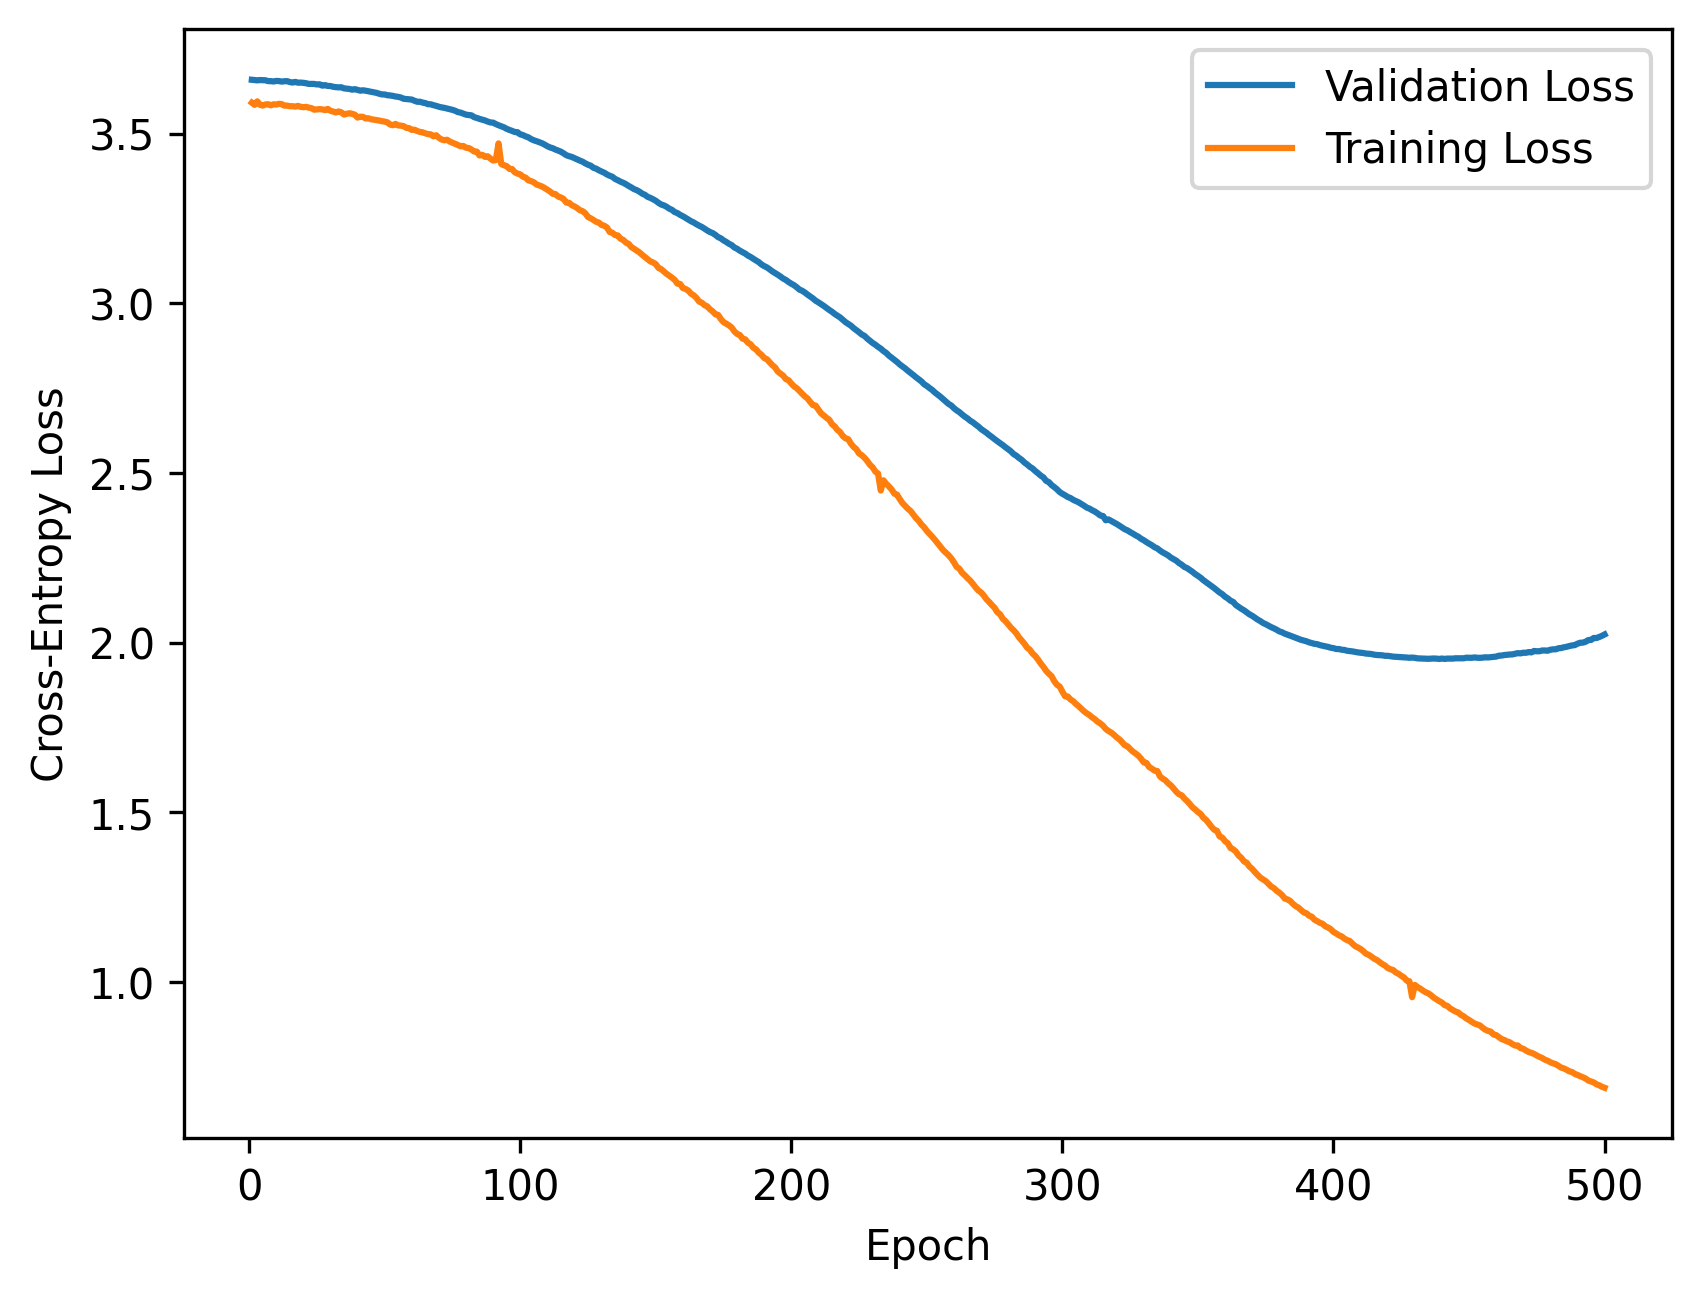

In [7]:
x = np.arange(1, 501)

plt.figure(dpi = 300)
plt.plot(x, validation_losses, label="Validation Loss")
plt.plot(x, training_losses, label="Training Loss")

plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('')
plt.legend()

plt.show()